# Detecção de Fraude em Cartões de Crédito com Dataset Real e Interpretável

**Objetivo:** Este notebook implementa um modelo de Machine Learning para detectar transações fraudulentas utilizando um dataset público do Kaggle com features claras e intuitivas. O foco é aplicar um pré-processamento robusto e lidar com o desbalanceamento de classes, simulando um cenário de negócio real.

### 1. Carregamento e Preparação Inicial

**Instruções:**
1. Certifique-se de que o arquivo `card_transdata.csv` está na mesma pasta que este notebook.

In [1]:
import pandas as pd
import numpy as np
import warnings

# Ferramentas do Scikit-learn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, roc_auc_score

# Modelo de Machine Learning
from lightgbm import LGBMClassifier

# Bibliotecas para visualização
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

### 2. Análise Exploratória dos Dados (EDA)

Formato do dataset: (1000000, 8)

Visualização das primeiras linhas:
   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           

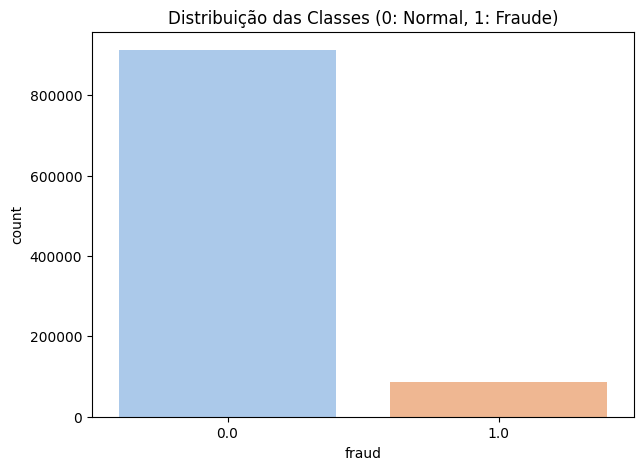

In [2]:
# Carregando os dados
df = pd.read_csv('card_transdata.csv')

print("Formato do dataset:", df.shape)
print("\nVisualização das primeiras linhas:")
print(df.head())

# Verificando o desbalanceamento das classes (agora a coluna alvo é 'fraud')
class_counts = df['fraud'].value_counts()
print("\nDistribuição das Classes:")
print(class_counts)

fraude_percentual = (class_counts[1] / class_counts.sum()) * 100
print(f"\nPercentual de Fraudes: {fraude_percentual:.2f}%")

# Visualizando a distribuição
plt.figure(figsize=(7, 5))
sns.countplot(x='fraud', data=df, palette='pastel')
plt.title('Distribuição das Classes (0: Normal, 1: Fraude)')
plt.show()

### 3. Treinamento e Avaliação do Modelo com Pipeline e Validação Cruzada

Iniciando avaliação com Validação Cruzada (5 dobras)...

--- Processando Dobra 1/5 ---
[LightGBM] [Info] Number of positive: 69923, number of negative: 730077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.087404 -> initscore=-2.345755
[LightGBM] [Info] Start training from score -2.345755
Recall (Fraudes Detectadas): 0.9996
Precisão (Acertos entre as detecções): 0.9769
ROC AUC Score: 1.0000
--- Processando Dobra 2/5 ---
[LightGBM] [Info] Number of positive: 69923, number of negative: 730077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050041 seconds.
You can set `force_row_wise=true` to remove t

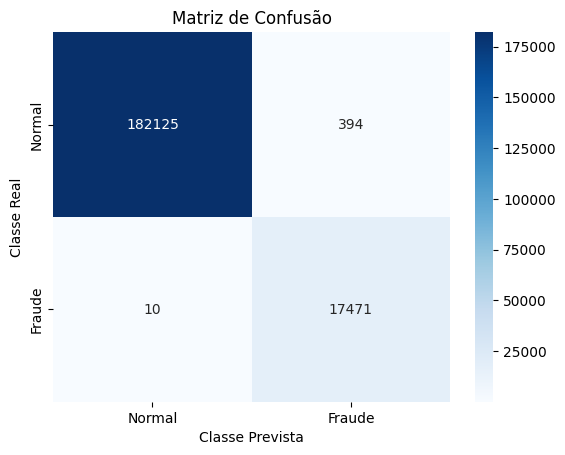

In [3]:
# Definindo as features (X) e o alvo (y)
X = df.drop('fraud', axis=1)
y = df['fraud']

# Identificando as colunas numéricas que precisam de escalonamento
numeric_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

# Criando o transformador de colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'  # Mantém as outras colunas (que são binárias) intactas
)

# --- Hiperparâmetros do Modelo ---
ratio = class_counts[0] / class_counts[1]
lgbm = LGBMClassifier(
    objective='binary',
    metric='auc',
    scale_pos_weight=ratio, # Parâmetro CRÍTICO para dados desbalanceados
    random_state=42,
    n_jobs=-1
)

# --- Criando o Pipeline Completo ---
# O Pipeline irá primeiro aplicar o pré-processamento e depois treinar o modelo
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgbm)
])

# --- Estratégia de Validação Robusta ---
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

print(f"Iniciando avaliação com Validação Cruzada ({n_splits} dobras)...\n")

# Listas para armazenar as métricas de cada dobra
recall_scores = []
precision_scores = []
auc_scores = []
fold_idx = 1

# Loop de Validação Cruzada
for train_index, test_index in skf.split(X, y):
    print(f"--- Processando Dobra {fold_idx}/{n_splits} ---")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Treinando o pipeline
    model_pipeline.fit(X_train, y_train)
    
    # Fazendo previsões
    y_pred = model_pipeline.predict(X_test)
    y_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probabilidades para a classe 1 (fraude)
    
    # Calculando e armazenando as métricas
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    recall_scores.append(recall)
    precision_scores.append(precision)
    auc_scores.append(auc)
    
    print(f"Recall (Fraudes Detectadas): {recall:.4f}")
    print(f"Precisão (Acertos entre as detecções): {precision:.4f}")
    print(f"ROC AUC Score: {auc:.4f}")
    
    fold_idx += 1

# --- Resultados Finais ---
print("\n--- Média dos Resultados da Validação Cruzada ---")
print(f"Recall Médio: {np.mean(recall_scores):.4f} (± {np.std(recall_scores):.4f})")
print(f"Precisão Média: {np.mean(precision_scores):.4f} (± {np.std(precision_scores):.4f})")
print(f"ROC AUC Médio: {np.mean(auc_scores):.4f} (± {np.std(auc_scores):.4f})")

# Visualizando a Matriz de Confusão da última dobra para referência
print("\nMatriz de Confusão (Última Dobra):")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraude'], yticklabels=['Normal', 'Fraude'])
plt.title('Matriz de Confusão')
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()